# Dependecies, imports and some basic process

In [ ]:
! pip install datasets

In [ ]:
!pip install huggingface_hub

In [ ]:
! pip install transformers

In [ ]:
import datasets
print(datasets.__version__)

In [ ]:
import huggingface_hub
print(huggingface_hub.__version__)

In [ ]:
from datasets import load_dataset
ds = load_dataset('cornell-movie-review-data/rotten_tomatoes', split='train')

it supported in the prev versions so it will not work

instead you can use "You can find the list of datasets on the Hub or with huggingface_hub.list_datasets."

In [ ]:
from huggingface_hub import list_datasets

In [ ]:
from transformers import pipeline

In [ ]:
from huggingface_hub import list_datasets

datasets = list_datasets(limit=10)

for dataset in datasets:
    print(dataset.id)


In [ ]:
from datasets import load_dataset

In [ ]:
dataset = load_dataset("emotion")

In [ ]:
print(dataset)

In [ ]:
dataset["train"][:10]

In [ ]:
train_ds = dataset["train"]
print(train_ds.features)


In [ ]:
train_ds.features['label']

In [ ]:
import pandas as pd

train_ds.set_format(type="pandas")
df = train_ds[:]
df.head()

In [ ]:
def label_int2str(row):
    # print(row)
    return train_ds.features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

before any trainig specially the classification, look at the data distribution

In [ ]:
import matplotlib.pyplot as plt
df['label_name'].value_counts(ascending=True).plot.barh()
plt.title("Freq of Classes")
plt.show()

 There are several ways to deal with imbalanced data, including:

Randomly oversample the minority class.

Randomly undersample the majority class.

Gather more labeled data from the underrepresented classes.

In [ ]:
df['Words per tweet']=df['text'].str.split().apply(len)
df.boxplot('Words per tweet',by="label_name",grid = False,showfliers=False)
plt.suptitle("")
plt.xlabel("")
plt.show()

Most people write around 15 to 20 words per tweet

In [ ]:
train_ds.reset_format()


In [ ]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

In [ ]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

In [ ]:
len(token2idx)

In [ ]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

In [ ]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

In [ ]:
input_ids

In [ ]:
one_hot_encodings


> When using pretrained models, it is really important to make sure that you use the same tokenizer that the model was trained with. From the model’s perspective, switching the tokenizer is like shuffling the vocabulary. If everyone around you started swapping random words like “house” for “cat,” you’d have a hard time understanding what was going on too!



# Tokenization the whole dataset


In [ ]:
from transformers import AutoTokenizer

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")


In [ ]:
text

In [ ]:
encoded_text = tokenizer(text)
print(encoded_text)

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

- some special [CLS] and [SEP] tokens have been added to the start and end of the sequence. These tokens differ from model to model, but their main role is to indicate the start and end of a sequence
- we can see that “tokenizing” and “NLP” have been split into two tokens, which makes sense since they are not common words.
- The ## prefix in ##izing and ##p means that the preceding string is not whitespace, any token with this prefix should be merged with the previous token when you convert the tokens back to a string.

In [ ]:
print(tokenizer.convert_tokens_to_string(tokens))


we can inspect the vocabulary size for this tokenizer

In [ ]:
tokenizer.vocab_size


In [ ]:
tokenizer.vocab

In [ ]:
tokenizer.model_max_length


attribute to know about is the names of the fields that the model expects in its forward pass:

In [ ]:
tokenizer.model_input_names


- padding=True will pad the examples with zeros to the size of the longest one in a batch,
- and truncation=True will truncate the examples to the model’s maximum context size.

In [ ]:
emotions_ds = dataset

In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [ ]:
print(tokenize(train_ds[:2]))


the first element of input_ids is shorter than the second, so zeros have been added to that element to make them the same length

>the tokenizer returns a list of attention_mask arrays. This is because we do not want the model to get confused by the additional padding tokens: the attention mask allows the model to ignore the padded parts of the input. Figure 2-3 provides a visual explanation of how the input IDs and attention masks are padded.
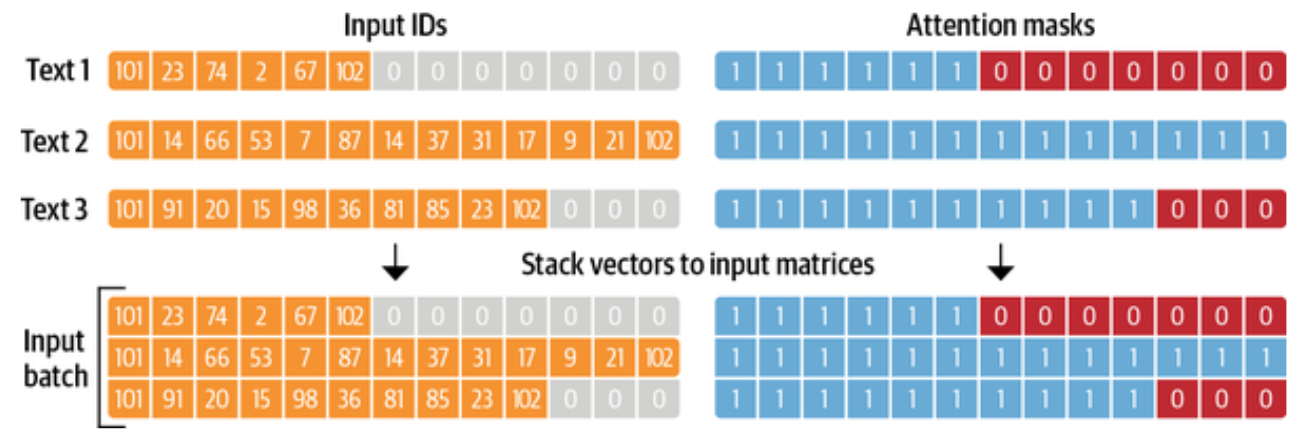
attention-mask
Figure 2-3. For each batch, the input sequences are padded to the maximum sequence length in the batch; the attention mask is used in the model to ignore the padded areas of the input tensors



- By default, the map() method operates individually on every example in the corpus, so setting batched=True will encode the tweets in batches. Because we’ve set batch_size=None, our tokenize() function will be applied on the full dataset as a single batch. This ensures that the input tensors and attention masks have the same shape globally,
____________________

- Why do this? It makes sure that when you create tensors (arrays of numbers for your model), every input and its matching attention mask have the same size throughout the dataset.

- Why is that important? Models need all input data in a batch to have matching shapes (sizes), so this avoids shape mismatches later when training or making predictions.
___________
- avoid using a single large batch if your data is huge, if you need fast or ongoing results, or if you want to update your model frequently. Using smaller batches usually gives you more flexibility, requires less memory, and helps when your data or task is dynamic.

In [ ]:
emotions_encoded = emotions_ds.map(tokenize,batched = True, batch_size=None)

this operation has added new input_ids and attention_mask columns to the dataset:

In [ ]:
print(emotions_encoded)

In [ ]:
emotions_encoded['train']["input_ids"]

In [ ]:
len(emotions_encoded['train']["text"])

In [ ]:
emotions_encoded['train']["attention_mask"]

We have two options to train such a model on our Twitter dataset:

- Feature extraction

  We use the hidden states as features and just train a classifier on them, without modifying the pretrained model.

- Fine-tuning

  We train the whole model end-to-end, which also updates the parameters of the pretrained model.

In [ ]:
from transformers import AutoModel
model_ckpt = "distilbert/distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

**AutoModel** has a **from_pretrained**() method to load the weights of a pretrained model.

The AutoModel class converts the token encodings to embeddings, and then feeds them through the encoder stack to return the hidden states. Let’s take a look at how we can extract these states from our corpus.

In [ ]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

In [ ]:
inputs

In [ ]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

 torch.no_grad() context manager to disable the automatic calculation of the gradient. This is useful for inference since it reduces the memory footprint of the computations.

Think of the last hidden state as the deep, contextual fingerprint of each word in your sentence after the model has "read" it deeply, and we use these fingerprints to do actual tasks like categorizing the sentence or answering questions about it.

In [ ]:
outputs.last_hidden_state.size()


In [ ]:
tokenizer.model_input_names

In [ ]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

we place the final hidden state back on the CPU as a NumPy array.

In [ ]:
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

 the last hidden state is a kind of embedding—but specifically the context-aware output embedding from the last transformer layer, not the simple static embeddings from the model’s initial embedding lookup.
 In practical NLP tasks, the last hidden state is usually preferred as the representation of tokens because it captures richer, dynamic meanings based on the sentence or input text.

In [ ]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)


In [ ]:
type(emotions_hidden)

###Creating a feature matrix


In [ ]:
import numpy as np

X_train = np.array(emotions_hidden['train']["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden['train']["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

* MinMaxScaler() adjusts all feature values in X_train so that every column (feature) lies between 0 and 1.
* This scaling helps UMAP work better, as many algorithms perform poorly if features have very different ranges.


In [ ]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

In [ ]:
X_scaled = MinMaxScaler().fit_transform(X_train)


* Create a UMAP object asking for 2 output dimensions (n_components=2), which is good for visualization.

* Use "cosine" similarity to measure distances, which is often suitable for text/vector data (like embeddings).

* .fit(X_scaled) runs UMAP on your scaled training data to learn the best way to squash high-dimensional data into 2D.


In [ ]:
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)


* After UMAP fits the data, mapper.embedding_ holds the new 2D coordinates for each data point.

* Create a Pandas DataFrame with these coordinates, naming the columns "X" and "Y".

* Add the y_train labels as a new column—this lets you color or analyze points by their label in your visualization.

* .head() displays the first few rows of the DataFrame so you can see the transformed data.


In [ ]:
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels =train_ds.features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

From this plot we can see some clear patterns: the negative feelings such as sadness, anger, and fear all occupy similar regions with slightly varying distributions. On the other hand, joy and love are well separated from the negative emotions and also share a similar space. Finally, surprise is scattered all over the place

# **Training a simple classifier**

In [ ]:
from sklearn.linear_model import LogisticRegression

# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

In [ ]:
 from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

We can see that anger and fear are most often confused with sadness, which agrees with the observation we made when visualizing the embeddings. Also, love and surprise are frequently mistaken for joy.

# Fine-Tuning Transformers


1. Loading a pretrained model


The main difference is AutoModel loads only the base pretrained model (like BERT or DistilBERT) and outputs hidden states or embeddings, while AutoModelForSequenceClassification loads the base model plus an added classification head (a linear layer) on top, allowing the model to output logits for classification tasks.

    AutoModel:

        Returns the model's hidden states (contextual embeddings for each token).

        Use this if you want to extract features or embeddings, not predictions.

        Does not include any task-specific layers for classification, question answering, etc.

AutoModelForSequenceClassification:

    Adds a classification head (usually a linear layer) to the end of the base model.

    Outputs logits for class prediction, used for tasks like sentiment or topic classification.

    The whole model (base + head) is trainable for your specific task

In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt,num_labels=num_labels).to(device))

2. Defining the performance metrics


In [ ]:
from sklearn.metrics import accuracy_score,f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels,preds,average='weighted')
  acc = accuracy_score(labels,preds)
  return {"accuracy":acc,"f1":f1}

3. Training the model





In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded['train'])// batch_size
model_name = f"{model_ckpt}-fintuned-emotion"
trainig_args = TrainingArguments(output_dir=model_name,
                                 num_train_epochs=2,
                                 learning_rate=2e-5,
                                 per_device_train_batch_size=batch_size,
                                per_device_eval_batch_size=batch_size,
                                 weight_decay = 0.01,
                                #  evaluation_strategy = "epoch",
                                 disable_tqdm=False,
                                 logging_steps=logging_steps,
                                 push_to_hub=True,
                                 log_level='error')

In [ ]:
trainer =Trainer(model=model, args=trainig_args,
                 compute_metrics=compute_metrics,
                 train_dataset=emotions_encoded['train'],
                 eval_dataset=emotions_encoded['validation'],
                 tokenizer=tokenizer)
trainer.train();

In [ ]:
preds_output = trainer.predict(emotions_encoded["validation"])


In [ ]:
preds_output.metrics


In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)


In [ ]:
plot_confusion_matrix(y_preds, y_valid, labels)


# Error analysis
